In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os



In [2]:
# File paths for 2021-2024
file_path_2021 = "../dataset/chennai-ground-water-levels-2021.csv"
file_path_2022 = "../dataset/chennai-ground-water-levels-2022.csv"
file_path_2023 = "../dataset/chennai-ground-water-levels-2023.csv"
file_path_2024 = "../dataset/chennai-ground-water-levels-2024.csv"

# Load datasets
df_2021 = pd.read_csv(file_path_2021)
df_2022 = pd.read_csv(file_path_2022)
df_2023 = pd.read_csv(file_path_2023)
df_2024 = pd.read_csv(file_path_2024)

# List of monthly columns
monthly_columns = ["Jan ", "Feb", "Mar", "Apr ", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]



In [3]:
# Data Preparation: Ensure all datasets have necessary columns
def prepare_data(df, year=None):
    if year == 2024:
        df[monthly_columns[3:]] = np.nan  # Set Apr-Dec to NaN for 2024
    df[monthly_columns] = df[monthly_columns].apply(pd.to_numeric, errors='coerce')
    df["Yearly Average"] = df[monthly_columns].mean(axis=1)
    return df



In [4]:
# Apply preparation function
df_2021 = prepare_data(df_2021, 2021)
df_2022 = prepare_data(df_2022, 2022)
df_2023 = prepare_data(df_2023, 2023)
df_2024 = prepare_data(df_2024, 2024)

# Add Year Column
df_2021["Year"] = 2021
df_2022["Year"] = 2022
df_2023["Year"] = 2023
df_2024["Year"] = 2024

# Combine all datasets
df_all_years = pd.concat([df_2021, df_2022, df_2023, df_2024])


In [5]:
# Step 1: Identify Wards with Significant Post-Monsoon Rises
df_all_years["Post-Monsoon Rise"] = df_all_years["Oct"] - df_all_years["Jun"]

# Calculate mean post-monsoon rise for comparison
mean_rise = df_all_years["Post-Monsoon Rise"].mean()

# Flag wards with high recharge potential
df_all_years["Recharge Potential"] = df_all_years["Post-Monsoon Rise"].apply(lambda x: "High" if x > mean_rise else "Low")




In [6]:
# Step 2: Identify Wards with Consistently Low Levels
low_level_threshold = df_all_years["Yearly Average"].quantile(0.25)
df_all_years["Low Level"] = df_all_years["Yearly Average"].apply(lambda x: "Yes" if x < low_level_threshold else "No")



In [7]:
# Step 3: Highlight Recharge Potential Areas
recharge_areas = df_all_years[(df_all_years["Recharge Potential"] == "High") | (df_all_years["Low Level"] == "Yes")]


In [8]:
# Create directory for saving plots
output_dir = "recharge_potential"
os.makedirs(output_dir, exist_ok=True)

# Step 4: Split Locations into Groups of 6
locations = df_all_years["Location"].unique()
num_plots = int(np.ceil(len(locations) / 6))  # Calculate number of plots needed

# Step 5: Loop through each year and generate plots
years = [2021, 2022, 2023, 2024]
for year in years:
    df_year = df_all_years[df_all_years["Year"] == year]  # Filter data for specific year

    for i in range(num_plots):
        plt.figure(figsize=(12, 6))

        start_idx = i * 6
        end_idx = min(start_idx + 6, len(locations))  # Ensure we don't exceed array bounds
        selected_locations = locations[start_idx:end_idx]

        for location in selected_locations:
            subset = df_year[df_year["Location"] == location]

            if not subset.empty:  # Ensure the location exists in this year's data
                values = subset[monthly_columns].iloc[0].values  
                plt.plot(monthly_columns, values, marker='o', label=location)

        # Prepare plot title and filename
        plot_title = f"Recharge Potential in {year} (Wards {start_idx + 1}-{end_idx})"
        plt.xlabel("Months")
        plt.ylabel("Groundwater Level (m)")
        plt.title(plot_title)
        plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), title="Wards")
        plt.grid()
        plt.tight_layout()

        # Save plot
        sanitized_title = plot_title.replace(" ", "_").replace(":", "").replace("(", "").replace(")", "")
        plt.savefig(os.path.join(output_dir, f"{sanitized_title}.png"))
        plt.close()

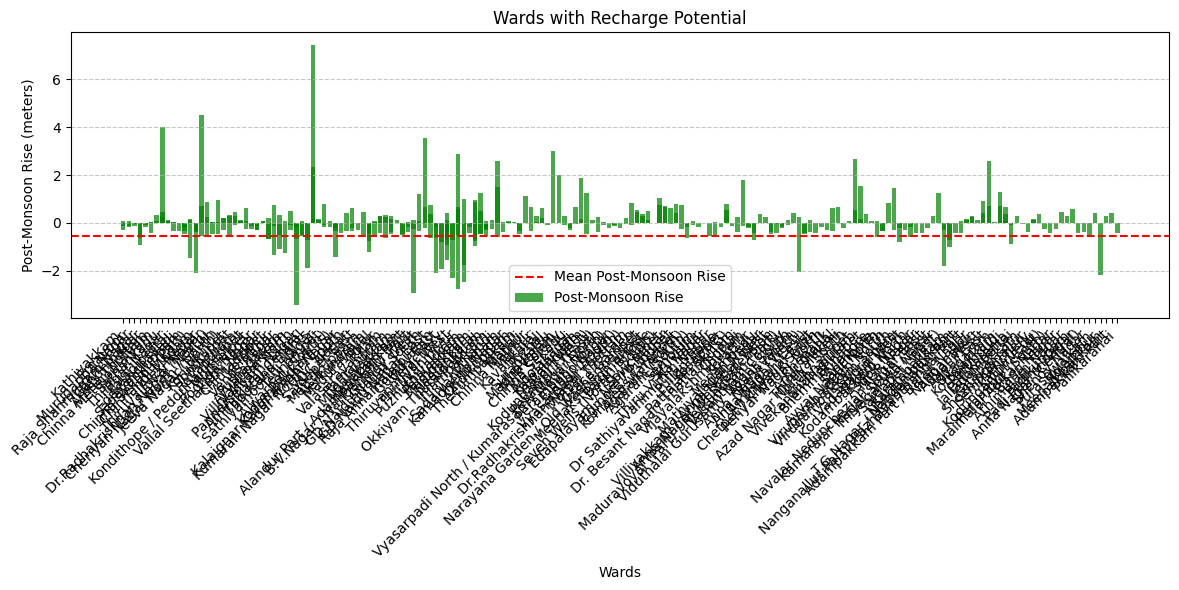


Wards with High Recharge Potential or Consistently Low Levels:
                                      Location  Year  Yearly Average  \
0                                  Kathivakkam  2021        1.788182   
1                                  Kathivakkam  2021        3.213250   
2                                     Ernavoor  2021        2.277083   
5                              Murugappa Nagar  2021        1.813500   
6                         Raja Shanmugam Nagar  2021        1.919250   
7                                  Gandhinagar  2021        4.451833   
8                                 Amsa Thottam  2021        6.925833   
9                         Chinna Mettupalaiyam  2021        5.463500   
11                                  Sathankadu  2021        3.509250   
12                              Thilagar Nagar  2021        1.183000   
13                                Kaladipettai  2021        5.248818   
14                               Edayanchavadi  2021        1.942417   


In [9]:
# Step 6: Visualization of Recharge Potential
plt.figure(figsize=(12, 6))
plt.bar(recharge_areas["Location"], recharge_areas["Post-Monsoon Rise"], color="green", alpha=0.7, label="Post-Monsoon Rise")
plt.axhline(y=mean_rise, color="red", linestyle="--", label="Mean Post-Monsoon Rise")
plt.title("Wards with Recharge Potential")
plt.xlabel("Wards")
plt.ylabel("Post-Monsoon Rise (meters)")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "Wards_with_Recharge_Potential.png"))
plt.show()

# Step 7: Display Insights
print("\nWards with High Recharge Potential or Consistently Low Levels:")
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
print(recharge_areas[["Location", "Year", "Yearly Average", "Post-Monsoon Rise", "Recharge Potential", "Low Level"]])

# Reset Pandas display options
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

# Optional: Save results to CSV
recharge_areas.to_csv(os.path.join(output_dir, "recharge_potential_areas.csv"), index=False)

C:\Users\rumma\AppData\Local\Temp\ipykernel_21680\4046725958.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_top10_rise, x="Location", y="change_2021_2024", palette="Blues_r")
C:\Users\rumma\AppData\Local\Temp\ipykernel_21680\4046725958.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


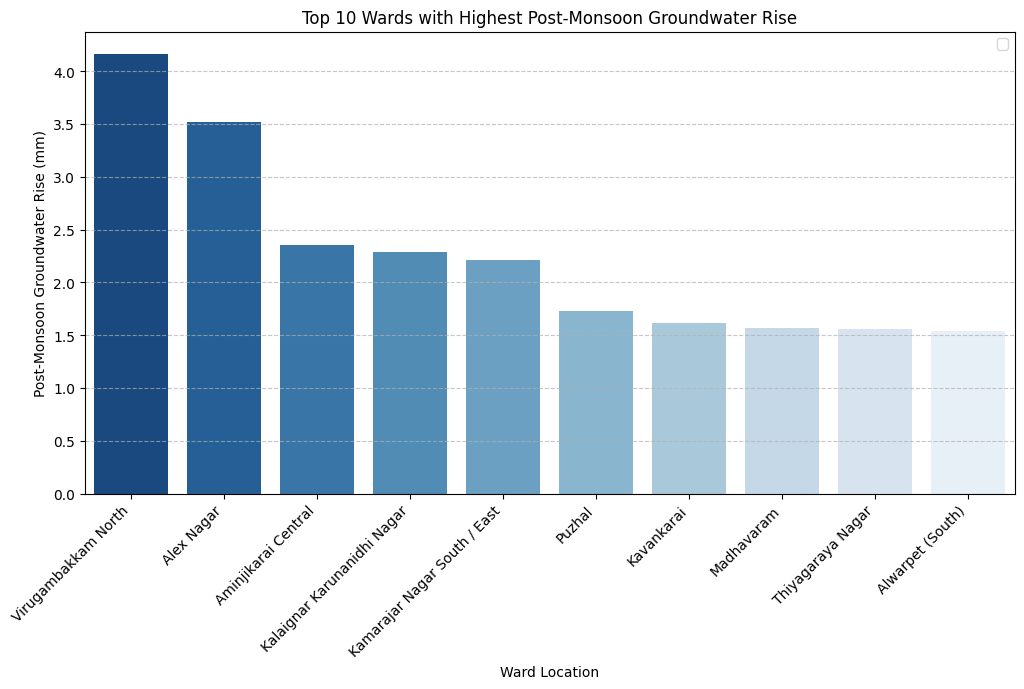

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load processed dataset
df_all_years = pd.read_csv("./output/location_based_groundwater_insights.csv")

# Sort wards by post-monsoon rise and select the top 10
df_top10_rise = df_all_years.sort_values("change_2021_2024", ascending=False).head(10)

# Plot the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(data=df_top10_rise, x="Location", y="change_2021_2024", palette="Blues_r")

plt.xlabel("Ward Location")
plt.ylabel("Post-Monsoon Groundwater Rise (mm)")
plt.title("Top 10 Wards with Highest Post-Monsoon Groundwater Rise")
plt.xticks(rotation=45, ha="right")
# plt.axhline(df_all_years["change_2021_2024"].mean(), color="red", linestyle="--", label="Mean Rise")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Save figure
plt.savefig("output/Post-Monsoon_Rise_Top10.png", dpi=300, bbox_inches="tight")
plt.show()
